In [118]:
import matplotlib.pyplot as plt
import torch 
import torch.nn as nn
import numpy as np
import torch.utils.data as data
from torch.utils.data import DataLoader, TensorDataset, random_split
import tifffile as tiff #load tiff image
from PIL import Image
import os
import torch
from torchvision import transforms
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from sklearn.cluster import KMeans
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from DataSet import myDataSet
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from dataset_2 import dataset_2
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [119]:
import torch
import time
#导入数据集
dataset = myDataSet(img_dir=r"C:\Users\zslig\Desktop\暑研课题_实地阶段\Gauss_S1.00_NL0.30_B0.50", group_size=10000)


In [120]:
#dataset类目前储存着完整数据集！！！不要打乱！！！

In [125]:
# 归一化处理，把所有像素值归一化到0-1
X=dataset.X #(10000,4,56,56)
Y=dataset.Y #(10000,1,56,56)
min_max_X_values = [] # 保存每个通道的 (min, max) 值
min_max_Y_values=[]
# 对X要分通道进行归一化
for i in range(4):
    x=X[:,i,:,:]
    x_max=x.max()
    x_min=x.min()
    min_max_X_values.append((x_min, x_max)) # 保存 min 和 max 值
    x_new=(x-x_min)/(x_max-x_min)
    X[:,i,:,:]=x_new
y_min=Y.min()
y_max=Y.max()
min_max_Y_values.append((y_min,y_max))
y_new=(Y-y_min)/(y_max-y_min)
Y=y_new


In [126]:
#更改x的形状
x_e=X[:,0,:,:]
x_h=X[:,1,:,:]
x_tn=X[:,2,:,:]
x_tp=X[:,3,:,:]
print(x_h.shape)


#下面是用行来拼接
X_trans=torch.cat((x_e,x_h,x_tn,x_tp),dim=2)
print(X_trans.shape)
print(Y.shape)
Y_trans=Y.reshape(10000, 56, 56)
print(X_trans.shape)
print(Y_trans.shape)

#下面是以列来拼接
#X_trans=torch.cat((x_e,x_h,x_tn,x_tp),dim=1)
#print(X_trans.shape)
#print(Y.shape)
#Y_trans=Y.reshape(10000, 56, 56)
#X_trans=X_trans.permute(0,2,1)
#Y_trans=Y_trans.permute(0,2,1)
#print(X_trans.shape)
#print(Y_trans.shape)

torch.Size([10000, 56, 56])
torch.Size([10000, 56, 224])
torch.Size([10000, 1, 56, 56])
torch.Size([10000, 56, 224])
torch.Size([10000, 56, 56])


In [131]:
# 输入定义为一句包含56个词语的句子，每个词汇表示为包含224个值的向量
# 输出定义为一句包含56个词语的句子，每个词汇表示为包含56个值的向量

import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset, random_split
from sklearn.model_selection import train_test_split


# 分割数据集为训练集、验证集和测试集
X_train, X_temp, Y_train, Y_temp = train_test_split(X_trans, Y_trans, test_size=0.2, random_state=42)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=42)

# 创建自定义数据集类
class CustomDataset(Dataset):
    def __init__(self, inputs, targets):
        self.inputs = inputs
        self.targets = targets

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return self.inputs[idx].clone().detach(), self.targets[idx].clone().detach()

# 创建数据集
train_dataset = CustomDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(Y_train, dtype=torch.float32))
val_dataset = CustomDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(Y_val, dtype=torch.float32))
test_dataset = CustomDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(Y_test, dtype=torch.float32))

# 定义超参数
input_dim = 224
hidden_dim = 224
output_dim = 56
num_layers = 2
seq_len = 56
batch_size = 32


# 创建数据加载器
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 定义模型
class EncoderDecoderModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=2):
        super(EncoderDecoderModel, self).__init__()
        self.encoder = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.decoder = nn.LSTM(hidden_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        # Encoder
        enc_out, hidden = self.encoder(x)
        
        # Decoder
        dec_out, _ = self.decoder(enc_out, hidden)
        
        # Fully connected layer to map hidden states to output dimension
        out = self.fc(dec_out)
        return out





C:\Users\zslig\AppData\Local\Temp\ipykernel_32452\808330527.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_dataset = CustomDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(Y_train, dtype=torch.float32))
C:\Users\zslig\AppData\Local\Temp\ipykernel_32452\808330527.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_dataset = CustomDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(Y_val, dtype=torch.float32))
C:\Users\zslig\AppData\Local\Temp\ipykernel_32452\808330527.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch

In [132]:
# 创建模型
model = EncoderDecoderModel(input_dim, hidden_dim, output_dim, num_layers)

# 定义损失函数和优化器
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:


# 训练模型
n_epochs = 300

for epoch in range(n_epochs):
    model.train()
    train_loss = 0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)
    
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for inputs, targets in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()
    val_loss /= len(val_loader)
    
    print(f'Epoch {epoch+1}, Train Loss: {train_loss}, Validation Loss: {val_loss}')

# 评估模型在测试集上的表现
model.eval()
test_loss = 0
with torch.no_grad():
    for inputs, targets in test_loader:
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        test_loss += loss.item()
test_loss /= len(test_loader)
print(f'Test Loss: {test_loss}')

Epoch 1, Train Loss: 0.0004187210161471739, Validation Loss: 0.000410008085964364
Epoch 2, Train Loss: 0.0003863274325849488, Validation Loss: 0.0003782031644732342
Epoch 3, Train Loss: 0.00035859188972972334, Validation Loss: 0.00035373345781408716
Epoch 4, Train Loss: 0.0003363495747325942, Validation Loss: 0.0003339919639984146
Epoch 5, Train Loss: 0.0003200310792308301, Validation Loss: 0.0003210544737157761
Epoch 6, Train Loss: 0.00030791559757199137, Validation Loss: 0.0003109122926616692
Epoch 7, Train Loss: 0.0002990024946630001, Validation Loss: 0.00030360364235093584
Epoch 8, Train Loss: 0.0002920938797760755, Validation Loss: 0.00029679001181648346
Epoch 9, Train Loss: 0.00028672183584421874, Validation Loss: 0.000293041658551374
Epoch 10, Train Loss: 0.00028246073133777826, Validation Loss: 0.0002892351376431179
Epoch 11, Train Loss: 0.00027869409660343083, Validation Loss: 0.0002853262494681985
Epoch 12, Train Loss: 0.0002756531564518809, Validation Loss: 0.000282772099126

In [33]:
#保存模型
torch.save(model, 'RNN_2_0.pth')

In [ ]:
#导出结果用于画图
input_test = X_test
target_test = Y_test
model.eval()
output_test = model(input_test)
error_test= target_test-output_test
flattened_error = torch.flatten(error_test)
flattened_index = torch.flatten(target_test)
errors_1 = [f for f,Y in zip(flattened_error,flattened_index) if Y !=0]
print(len(errors_1))
with torch.no_grad():
    error_array = np.array(errors_1)


In [ ]:
np.savetxt('errors_seq2seq_448d_LSTM.txt', error_array)
print('结果已导出')

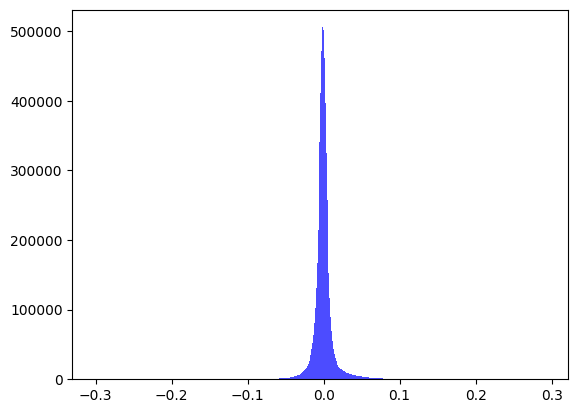

In [60]:
error_np=tensor.numpy()
plt.hist(error_np, bins=500, alpha=0.7, color='blue');

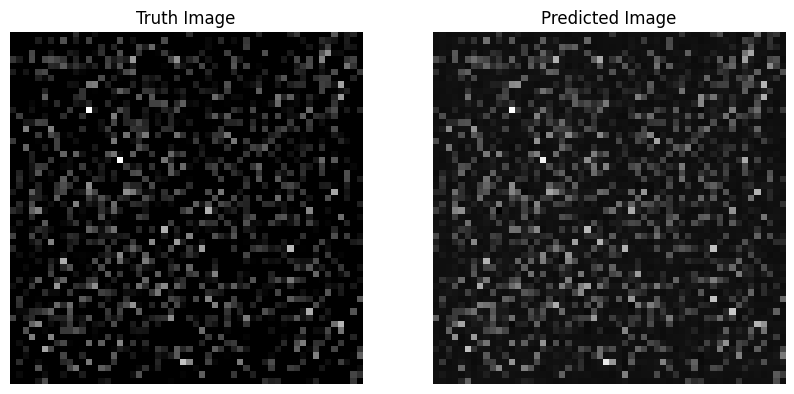

In [72]:
#下面是画效果图
output_np=output_test.detach().numpy()
target_np=target_test.detach().numpy()

#对比那一组数据？
i=720

# 创建一个 1x2 的子图布局
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# 绘制第一个灰度图aim_of_truth(56*56)
axes[0].imshow(target_np[i,:,:], cmap='gray')
axes[0].set_title('Truth Image')
axes[0].axis('off')  # 隐藏坐标轴

# 绘制第二个灰度图v_array(56*56)
axes[1].imshow(output_np[i,:,:], cmap='gray')
axes[1].set_title('Predicted Image')
axes[1].axis('off')  # 隐藏坐标轴

# 显示图像
plt.show()